## Question 3
(35%) Neural Networks and Gaussian process. 

Predict the SP500 with the financial indicators assigned to your team in the google spreadsheet (ep, dp, de, dy, dfy, bm, svar,
ntis, infl, tbl , see RLab3 2 GWcausalSP500.R), some lagged series of these indicators and lags of the target using a Neural Network and a GP regression with your desired kernel.

Predict return, or price, or direction (up or down). For which target works best? Do some feature selection to disregard some variables, select appropriate lags: causality, (distance) correlation, VAR-test, Lasso ... (The script RLab5 GausProc.R can be of help. The dataset is goyal-welch2022Monthly.csv and work within the period 1927/2021.)

In [5]:
# bm, ep, ntis

In [79]:
# Packages
import os
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [76]:
def compute_reg_metrics(y, y_pred):
    R2 = np.round(r2_score(y, y_pred), 5)
    RMSE = np.round(mean_squared_error(y, y_pred), 6)
    return R2, RMSE

def regression_metrics(y_train, y_train_pred, y_test, y_test_pred):
    r2_train, rmse_train = compute_reg_metrics(y_train, y_train_pred)
    r2_test, rmse_test = compute_reg_metrics(y_test, y_test_pred)

    print(' --- TRAIN --- ')
    print(f' R2: {r2_train}')
    print(f' RMSE: {rmse_train}')

    print(' --- TEST --- ')
    print(f' R2: {r2_test}')
    print(f' RMSE: {rmse_test}')
    print(f' Gap RMSE: {rmse_test - rmse_train}')

def compute_class_metrics(y, y_pred):
    acc = np.round(accuracy_score(y, y_pred), 5)
    prec = np.round(precision_score(y, y_pred), 5)
    recall = np.round(recall_score(y, y_pred), 5)
    f1score = np.round(f1_score(y, y_pred), 5)
    return acc, prec, recall, f1score

def classification_metrics(y_train, y_train_pred, y_test, y_test_pred):
    acc, prec, recall, f1score = compute_class_metrics(y_train, y_train_pred)
    acc_, prec_, recall_, f1score_ = compute_class_metrics(y_test, y_test_pred)

    print(' --- TRAIN --- ')
    print(f' Accuracy: {acc}')
    print(f' Precision: {prec}')
    print(f' Recall: {recall}')
    print(f' F1-score: {f1score}')

    print(' --- TEST --- ')
    print(f' Accuracy: {acc_}')
    print(f' Precision: {prec_}')
    print(f' Recall: {recall_}')
    print(f' F1-score: {f1score_}')

In [8]:
DATA_DIR = 'data'

# Frequency of sampling
tau = 1 #data is monthly. Try tau=12 (year), tau=3 (quarterly)

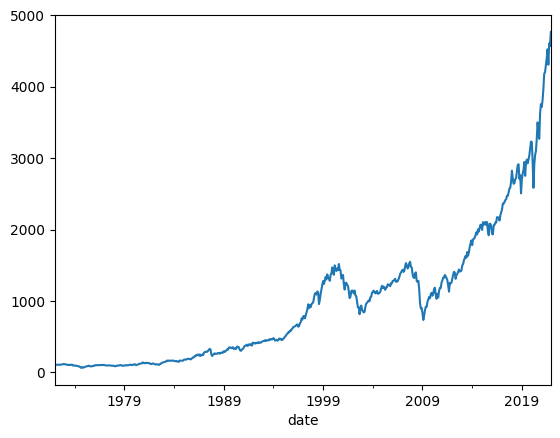

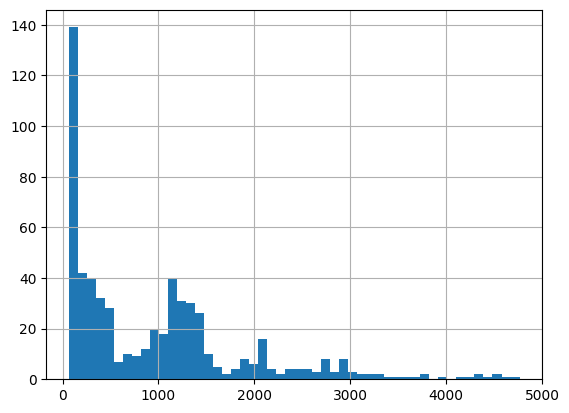

In [9]:
file = 'goyal-welch2022Monthly.csv'
df = pd.read_csv(os.path.join(DATA_DIR, file)) #,
                   #usecols=['yyyymm', 'Index', 'b/m', 'ep', 'ntis'])

df['Index'] = df['Index'].apply(lambda x: x.replace(',', '')).astype(float)
df['date'] = pd.to_datetime(df['yyyymm'], format='%Y%m')

dateI = "1972-01-01"
dateF = "2021-12-31"
df = df.query(f'date >= "{dateI}" & date <= "{dateF}"')

### Compute dp, de, ep, dy, dfy
# dividend-price ratio (dp)
df['dp'] = np.log(df['D12']) - np.log(df['Index'])
# dividend-payout ratio (de)
df['de'] = np.log(df['D12']) - np.log(df['E12'])
# earnings to price
df['ep'] = np.log(df['E12']) - np.log(df['Index'])
## dividend yield (remove 1st since lag puts NA in 1st entry)
df['dy'] = np.log(df['D12'].shift(-1)) - np.log(df['Index'].shift(-1))
# Default yield spread (dfy)= BAA-AAA rated corporate bond yields:
df['dfy'] = df['BAA'] - df['AAA']  # Assuming 'BAA' and 'AAA' columns are available

df.set_index('date')['Index'].plot()
plt.show()

df.set_index('date')['Index'].hist(bins=50)
plt.show()

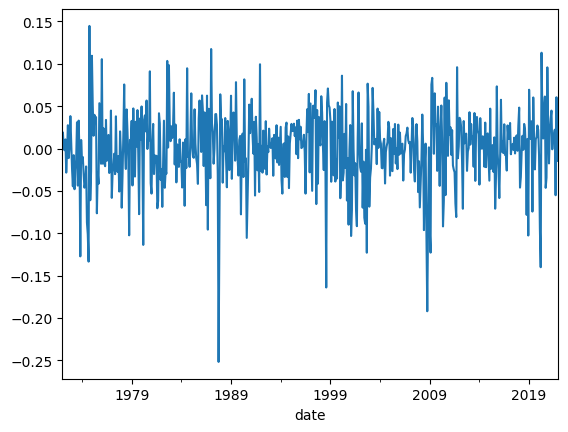

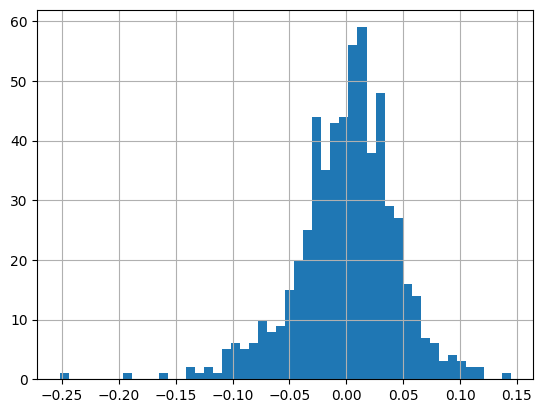

In [10]:
# Option 2. Target as Return
df['return'] = np.log(df['Index']).diff(tau)
# try non-center (above) /center target (below)
mean_target = df['return'].mean()
df['return'] = df['return'] - mean_target ##Center the target

df.set_index('date')['return'].plot()
plt.show()

df.set_index('date')['return'].hist(bins=50)
plt.show()

direction
True     363
False    237
Name: count, dtype: int64


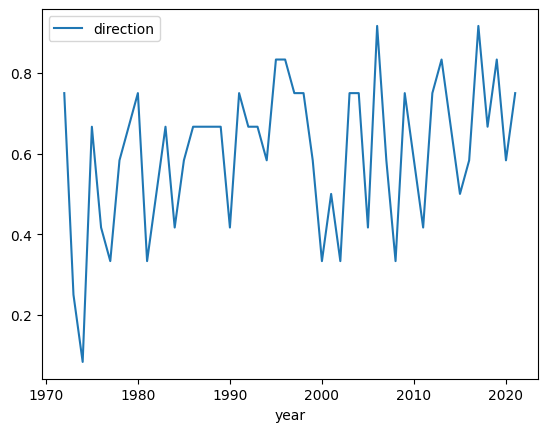

In [11]:
# Option 3. Direction (up or down).
df['direction'] = df['Index'].diff(tau) > 0

df['year'] = (df['yyyymm'] / 100).astype(int)

print(df['direction'].value_counts())

#plt.scatter(df['date'], df['direction'].astype(int), alpha=0.5)
#plt.show()

df.groupby('year')['direction'].mean().to_frame().plot()
plt.show()

In [12]:
# Select TARGET
type_target = 'return'
if type_target == 'price':
    TARGET = 'Index'
elif type_target == 'return':
    TARGET = 'return'
else:
    TARGET = 'direction'

['ep', 'ntis', 'b/m']


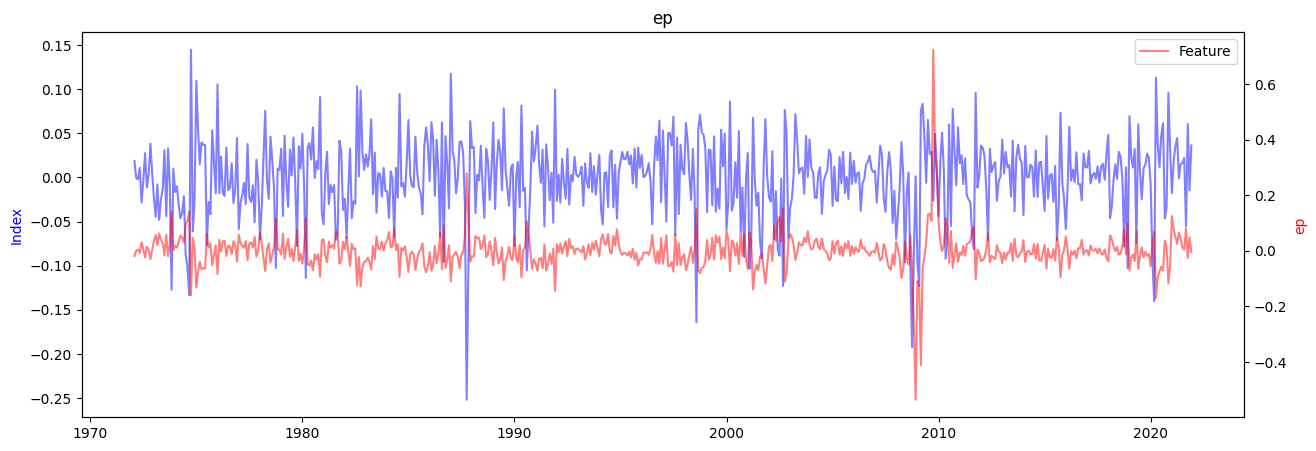

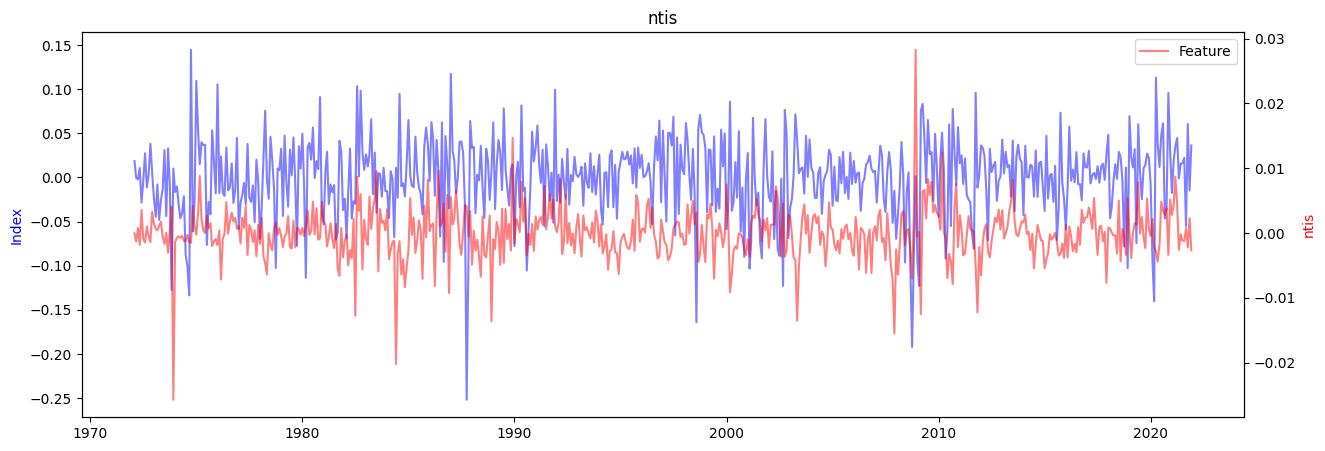

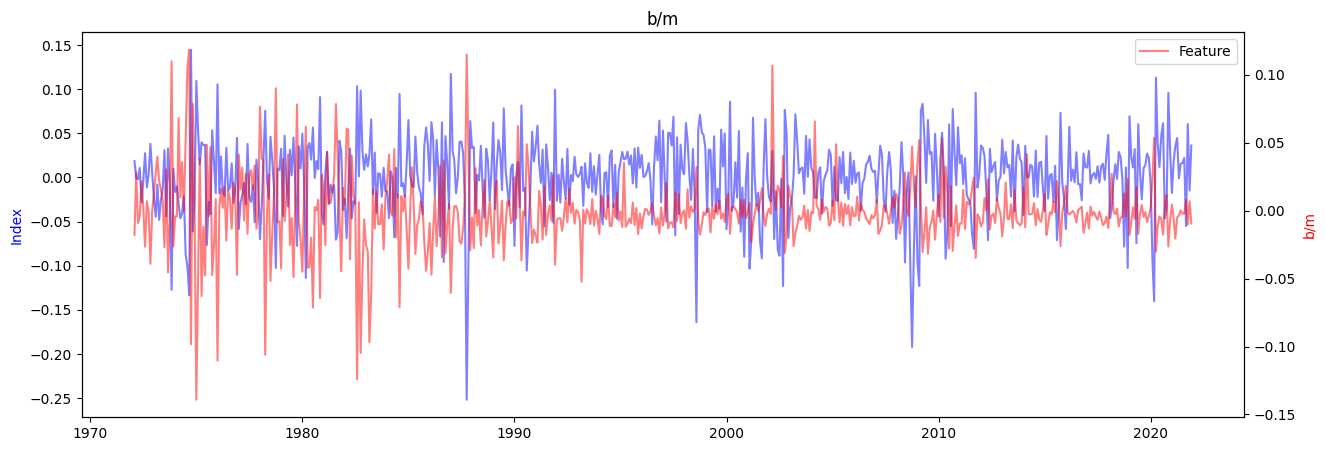

In [13]:
features = list(set(df.columns).intersection(['b/m', 'ntis', 'ep']))
print(features)

for feature in features:
    fig, ax1 = plt.subplots(figsize=(15, 5))
    
    ax1.plot(df['date'], df[TARGET], label='Index', color='blue', alpha=0.5)
    ax1.set_ylabel('Index', color='blue')
    
    ax2 = ax1.twinx()
    if TARGET == 'return':
        ax2.plot(df['date'], df[feature].diff(tau), label='Feature', color='red', alpha=0.5)
    else:
        ax2.plot(df['date'], df[feature], label='Feature', color='red', alpha=0.5)

    ax2.set_ylabel(feature, color='red')

    plt.title(f'{feature}')
    plt.legend()
    plt.show()

In [14]:
# Model Inputs:
# Define matrix of features (each column is a feature)
# Features: lags 1,2,3 with (or w/o) PE10 and lags 1,2

data = df.set_index('date')[features+[TARGET]]
print(features)

for feature in features+[TARGET]:
    data[f'{feature}_lag1'] = data[feature].shift(1)
    data[f'{feature}_lag2'] = data[feature].shift(2)
    data[f'{feature}_lag3'] = data[feature].shift(3)

new_features = list(set(data.columns).difference([TARGET]))
print(new_features)

data = data.dropna()
data.head()

['ep', 'ntis', 'b/m']
['ntis_lag1', 'b/m_lag1', 'ntis_lag2', 'b/m', 'ep_lag2', 'return_lag1', 'ntis_lag3', 'ep_lag1', 'ntis', 'return_lag2', 'ep_lag3', 'b/m_lag2', 'ep', 'return_lag3', 'b/m_lag3']


,ep,ntis,b/m,return,ep_lag1,ep_lag2,ep_lag3,ntis_lag1,ntis_lag2,ntis_lag3,b/m_lag1,b/m_lag2,b/m_lag3,return_lag1,return_lag2,return_lag3
date,,,,,,,,,,,,,,,,
1972-05-01,-2.918420,0.030657,0.632442,0.010741,-2.910358,-2.915116,-2.915558,0.032492,0.031723,0.033030,0.636784,0.645902,0.617586,-0.002012,-0.000492,0.018602
1972-06-01,-2.887389,0.034199,0.654015,-0.028449,-2.918420,-2.910358,-2.915116,0.030657,0.032492,0.031723,0.632442,0.636784,0.645902,0.010741,-0.002012,-0.000492
1972-07-01,-2.880267,0.033325,0.657050,-0.004056,-2.887389,-2.918420,-2.910358,0.034199,0.030657,0.032492,0.654015,0.632442,0.636784,-0.028449,0.010741,-0.002012
1972-08-01,-2.904793,0.031849,0.630467,0.027487,-2.880267,-2.887389,-2.918420,0.033325,0.034199,0.030657,0.657050,0.654015,0.632442,-0.004056,-0.028449,0.010741
1972-09-01,-2.890643,0.032870,0.637385,-0.011259,-2.904793,-2.880267,-2.887389,0.031849,0.033325,0.034199,0.630467,0.657050,0.654015,0.027487,-0.004056,-0.028449


In [15]:
# Time Series Train test split
T = len(data)
p = 0.75
trainindex = round(p*T)

# process class sets as data frames
training = data.iloc[:trainindex, :]
testing = data.iloc[trainindex:, :]

display(training.tail())
display(testing.head())

X_train, y_train = training[new_features], training[TARGET]
X_test, y_test = testing[new_features], testing[TARGET]

,ep,ntis,b/m,return,ep_lag1,ep_lag2,ep_lag3,ntis_lag1,ntis_lag2,ntis_lag3,b/m_lag1,b/m_lag2,b/m_lag3,return_lag1,return_lag2,return_lag3
date,,,,,,,,,,,,,,,,
2009-03-01,-4.756238,-0.037427,0.446141,0.075566,-4.345202,-4.214465,-4.105981,-0.024927,-0.025056,-0.024498,0.441103,0.389393,0.354984,-0.122843,-0.095936,0.001405
2009-04-01,-4.814910,-0.030993,0.415597,0.083386,-4.756238,-4.345202,-4.214465,-0.037427,-0.024927,-0.025056,0.446141,0.441103,0.389393,0.075566,-0.122843,-0.095936
2009-05-01,-4.836482,-0.024349,0.399355,0.045334,-4.814910,-4.756238,-4.345202,-0.030993,-0.037427,-0.024927,0.415597,0.446141,0.441103,0.083386,0.075566,-0.122843
2009-06-01,-4.807399,-0.022097,0.401876,-0.006191,-4.836482,-4.814910,-4.756238,-0.024349,-0.030993,-0.037427,0.399355,0.415597,0.446141,0.045334,0.083386,0.075566
2009-07-01,-4.677399,-0.013782,0.370126,0.065136,-4.807399,-4.836482,-4.814910,-0.022097,-0.024349,-0.030993,0.401876,0.399355,0.415597,-0.006191,0.045334,0.083386


,ep,ntis,b/m,return,ep_lag1,ep_lag2,ep_lag3,ntis_lag1,ntis_lag2,ntis_lag3,b/m_lag1,b/m_lag2,b/m_lag3,return_lag1,return_lag2,return_lag3
date,,,,,,,,,,,,,,,,
2009-08-01,-4.542775,-0.007921,0.357472,0.026623,-4.677399,-4.807399,-4.836482,-0.013782,-0.022097,-0.024349,0.370126,0.401876,0.399355,0.065136,-0.006191,0.045334
2009-09-01,-4.434342,-0.000014,0.349521,0.028714,-4.542775,-4.677399,-4.807399,-0.007921,-0.013782,-0.022097,0.357472,0.370126,0.401876,0.026623,0.065136,-0.006191
2009-10-01,-3.710527,0.003198,0.349505,-0.026346,-4.434342,-4.542775,-4.677399,-0.000014,-0.007921,-0.013782,0.349521,0.357472,0.370126,0.028714,0.026623,0.065136
2009-11-01,-3.357297,0.007532,0.328149,0.049393,-3.710527,-4.434342,-4.542775,0.003198,-0.000014,-0.007921,0.349505,0.349521,0.357472,-0.026346,0.028714,0.026623
2009-12-01,-3.085462,0.010594,0.325531,0.011228,-3.357297,-3.710527,-4.434342,0.007532,0.003198,-0.000014,0.328149,0.349505,0.349521,0.049393,-0.026346,0.028714


# Gaussian Process

These numbers represent hyperparameters and settings for Gaussian process (GP) regression using scikit-learn in Python:

- l: Length scale parameter for the squared exponential (SE) kernel. It controls the smoothness of the GP function. In this case, l = 0.003.
- C(1.5, (1e-3, 1e3)): Constant kernel with a constant value of 1.5 and bounds for optimization between 1e-3 and 1e3. This kernel adds a constant value to the diagonal of the kernel matrix, improving numerical stability.
- RBF(l, (1e-2, 1e2)): Radial basis function (RBF) kernel with a length scale of l and bounds for optimization between 1e-2 and 1e2. The RBF kernel, also known as the squared exponential kernel, is commonly used for modeling stationary processes.

These hyperparameters and settings are used to define the Gaussian process regressor (gaussian_process.GaussianProcessRegressor). The regressor is configured with the defined kernel (MyKer), an initial noise variance of 0.003 (alpha), normalization of the target values (normalize_y=True), 10 restarts for optimizer to find the maximum likelihood parameters (n_restarts_optimizer=10), and a random state for reproducibility (random_state=0).

In [16]:
# GP Kernel: vanilla is non-stationary; tanh, rbf are stationary
# Define my own Kernel (for vectors). You have 3 choices below:
# SE kernel with length scale l
l = 0.003  # 0.15, 0.3
MyKer = C(1.5, (1e-3, 1e3)) * RBF(l, (1e-2, 1e2))

# Define the Gaussian Process Regressor
gpfit = gaussian_process.GaussianProcessRegressor(
    kernel=MyKer,
    alpha=0.003,  # the initial noise variance: 0.001 default min value
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=0,
)

gpfit.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.003, kernel=1.22**2 * RBF(length_scale=0.003),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=0)

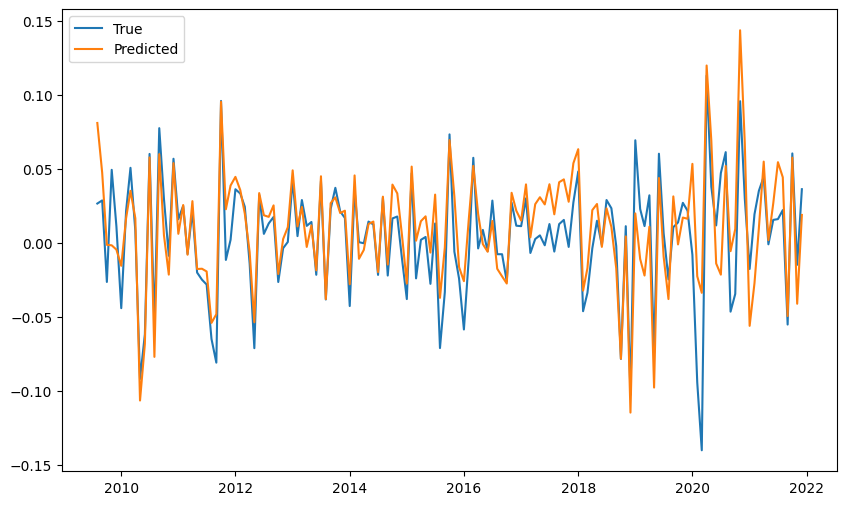

In [17]:
# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': gpfit.predict(X_test)})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_res['true'], label='True')
plt.plot(df_res['pred'], label='Predicted')
plt.legend()
plt.show()

In [18]:
regression_metrics(y_train, gpfit.predict(X_train), 
                   y_test, gpfit.predict(X_test)) 

 --- TEST --- 
 R2: 0.99935
 RMSE: 1e-06
 --- TEST --- 
 R2: 0.64398
 RMSE: 0.000555
 Gap RMSE: 0.000554


# How do we find the best parameters of the Gaussian Process? 
=> Optuna

In [19]:
# Create validation to evaluate performance
T = len(training)
p = 0.75
validindex = round(p*T)

# process class sets as data frames
training_ = training.iloc[:validindex, :]
valid_ = training.iloc[validindex:, :]

X_train_, y_train_ = training_[new_features], training_[TARGET]
X_valid, y_valid = valid_[new_features], valid_[TARGET]

In [20]:
import optuna

# Define the objective function
def objective(trial):
    # Define hyperparameters to be optimized
    l = trial.suggest_loguniform('l', 1e-3, 1e1)
    alpha = trial.suggest_float('alpha', 1e-4, 1e-1, log=True)
    C_value = trial.suggest_float('C_value', 0.5, 3)
    
    # Define the kernel
    MyKer = C(C_value, (1e-3, 1e3)) * RBF(l, (1e-2, 1e2))

    # Define the Gaussian Process Regressor with optimized hyperparameters
    gpfit = gaussian_process.GaussianProcessRegressor(
        kernel=MyKer,
        alpha=alpha,
        normalize_y=True,
        n_restarts_optimizer=10,
        random_state=0,
    )

    # Fit the GP regressor
    gpfit.fit(X_train_, y_train_)

    # Predict on the validation set
    y_pred = gpfit.predict(X_valid)

    # Calculate the mean squared error
    score = mean_squared_error(y_valid, y_pred)
    #score = r2_score(y_valid, y_pred)

    return score

# Define X_val and y_val for validation
# You need to define X_train and y_train as well

# Define study and optimize the objective function
study = optuna.create_study(direction='minimize') # 'maximize' for R2 | 'minimize' for RMSE
study.optimize(objective, n_trials=60)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-04-27 17:14:19,841] A new study created in memory with name: no-name-676c10a5-a95e-46d0-951b-63089edaa614


[I 2024-04-27 17:14:21,872] Trial 0 finished with value: 0.00298358300456343 and parameters: {'l': 1.8407880189453363, 'alpha': 0.01814584043105395, 'C_value': 1.7927936150209507}. Best is trial 0 with value: 0.00298358300456343.
[I 2024-04-27 17:14:24,146] Trial 1 finished with value: 0.0031592985686277946 and parameters: {'l': 2.6458983561673106, 'alpha': 0.0014975851419072735, 'C_value': 2.268957828785089}. Best is trial 0 with value: 0.00298358300456343.
[I 2024-04-27 17:14:25,890] Trial 2 finished with value: 0.002497871877452961 and parameters: {'l': 0.011513264384132879, 'alpha': 0.027090236166752928, 'C_value': 1.478053865841477}. Best is trial 2 with value: 0.002497871877452961.
[I 2024-04-27 17:14:28,224] Trial 3 finished with value: 0.003030185571797944 and parameters: {'l': 0.0020487928524939, 'alpha': 0.000517407270888846, 'C_value': 1.50661755599715}. Best is trial 2 with value: 0.002497871877452961.
[I 2024-04-27 17:14:30,520] Trial 4 finished with value: 0.0035434779070

Best hyperparameters: {'l': 8.046664016171498, 'alpha': 0.07549835105249349, 'C_value': 0.7052039321894104}


In [21]:
fig = optuna.visualization.plot_optimization_history(study, target_name='Validation CRPS')
fig.update_layout(autosize=True, width=800, height=500)
fig.show()

In [22]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(autosize=True, width=800, height=400)
fig.show()

In [23]:
params = study.best_params

MyKer = C(params['C_value'], (1e-3, 1e3)) * RBF(params['l'], (1e-2, 1e2))

# Define the Gaussian Process Regressor
gpfit = gaussian_process.GaussianProcessRegressor(
    kernel=MyKer,
    alpha=params['alpha'],  # the initial noise variance: 0.001 default min value
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=0,
)

gpfit.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.07549835105249349,
                         kernel=0.84**2 * RBF(length_scale=8.05),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=0)

In [24]:
regression_metrics(y_train, gpfit.predict(X_train), 
                   y_test, gpfit.predict(X_test)) 

 --- TEST --- 
 R2: 0.94396
 RMSE: 0.000116
 --- TEST --- 
 R2: 0.47347
 RMSE: 0.000821
 Gap RMSE: 0.000705


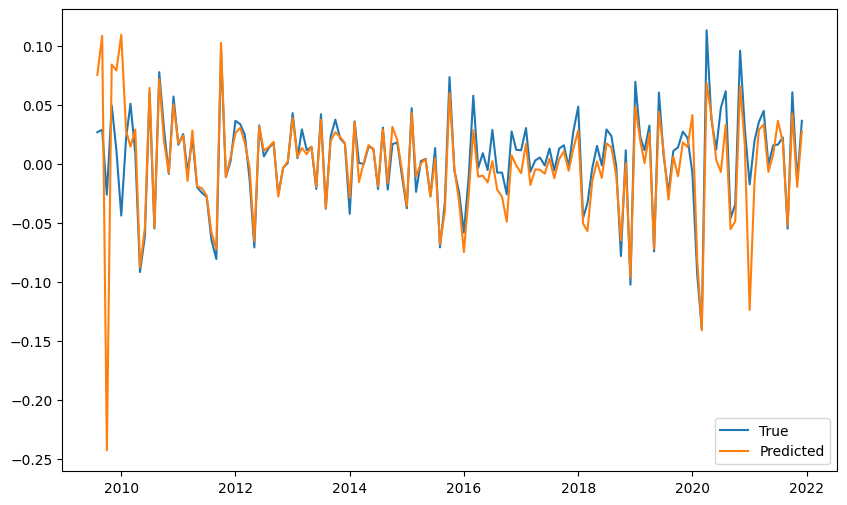

In [25]:
# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': gpfit.predict(X_test)})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_res['true'], label='True')
plt.plot(df_res['pred'], label='Predicted')
plt.legend()
plt.show()

# Neural Network

 --- TEST --- 
 R2: -0.03674
 RMSE: 0.00215
 --- TEST --- 
 R2: -0.31489
 RMSE: 0.002049
 Gap RMSE: -0.00010099999999999996


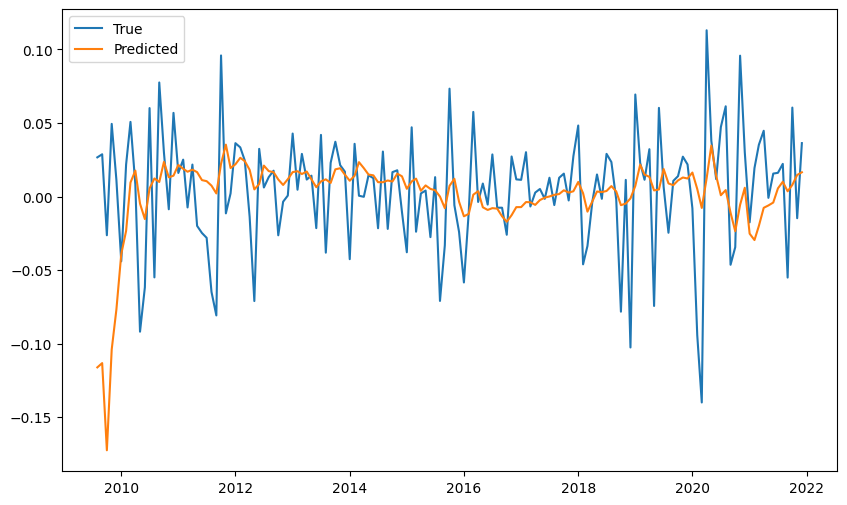

In [57]:
# Using multiple hidden layer with c(size, size, ...) many nodes
size = 40
mlp1 = MLPRegressor(
    hidden_layer_sizes=(size, size, size),
    max_iter=100000,
    activation="relu", #"logistic", # "tanh", "relu"
    solver="adam" # "lbfgs", "sgd"
)

mlp1.fit(X_train, y_train)

regression_metrics(y_train, mlp1.predict(X_train), 
                   y_test, mlp1.predict(X_test)) 

# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': mlp1.predict(X_test)})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_res['true'], label='True')
plt.plot(df_res['pred'], label='Predicted')
plt.legend()
plt.show()

 --- TEST --- 
 R2: 0.13615
 RMSE: 0.001791
 --- TEST --- 
 R2: 0.08944
 RMSE: 0.001419
 Gap RMSE: -0.00037200000000000015


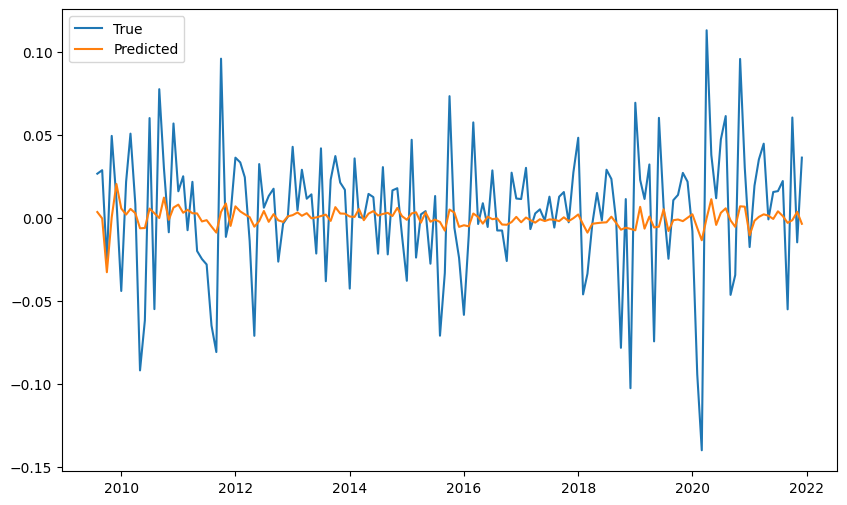

In [58]:
# Alternative using nnet with one hidden layer with size many nodes + skip layer
# Parameters to tune: size, weight decay (a regularization of tyoe L2 in penalty funct that shrinks weights)
size = 500
decay = 10 ** -2
mlp2 = MLPRegressor(
    hidden_layer_sizes=(size,), 
    max_iter=10000, 
    alpha=decay
)

mlp2.fit(X_train, y_train)

regression_metrics(y_train, mlp2.predict(X_train), 
                   y_test, mlp2.predict(X_test)) 

# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': mlp2.predict(X_test)})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_res['true'], label='True')
plt.plot(df_res['pred'], label='Predicted')
plt.legend()
plt.show()

# Binary classification

In [63]:
TARGET = 'direction'
data = df.set_index('date')[features+['return', TARGET]]
print(features)

for feature in features+['return']:
    data[f'{feature}_lag1'] = data[feature].shift(1)
    data[f'{feature}_lag2'] = data[feature].shift(2)
    data[f'{feature}_lag3'] = data[feature].shift(3)

new_features = list(set(data.columns).difference(['return', TARGET]))
print(new_features)

data = data.dropna()
data.head()

['ep', 'ntis', 'b/m']
['ntis_lag1', 'b/m_lag1', 'ntis_lag2', 'b/m', 'ep_lag2', 'return_lag1', 'ntis_lag3', 'ntis', 'ep_lag1', 'return_lag2', 'ep_lag3', 'b/m_lag2', 'ep', 'return_lag3', 'b/m_lag3']


,ep,ntis,b/m,return,direction,ep_lag1,ep_lag2,ep_lag3,ntis_lag1,ntis_lag2,ntis_lag3,b/m_lag1,b/m_lag2,b/m_lag3,return_lag1,return_lag2,return_lag3
date,,,,,,,,,,,,,,,,,
1972-05-01,-2.918420,0.030657,0.632442,0.010741,True,-2.910358,-2.915116,-2.915558,0.032492,0.031723,0.033030,0.636784,0.645902,0.617586,-0.002012,-0.000492,0.018602
1972-06-01,-2.887389,0.034199,0.654015,-0.028449,False,-2.918420,-2.910358,-2.915116,0.030657,0.032492,0.031723,0.632442,0.636784,0.645902,0.010741,-0.002012,-0.000492
1972-07-01,-2.880267,0.033325,0.657050,-0.004056,True,-2.887389,-2.918420,-2.910358,0.034199,0.030657,0.032492,0.654015,0.632442,0.636784,-0.028449,0.010741,-0.002012
1972-08-01,-2.904793,0.031849,0.630467,0.027487,True,-2.880267,-2.887389,-2.918420,0.033325,0.034199,0.030657,0.657050,0.654015,0.632442,-0.004056,-0.028449,0.010741
1972-09-01,-2.890643,0.032870,0.637385,-0.011259,False,-2.904793,-2.880267,-2.887389,0.031849,0.033325,0.034199,0.630467,0.657050,0.654015,0.027487,-0.004056,-0.028449


In [64]:
# Time Series Train test split
T = len(data)
p = 0.75
trainindex = round(p*T)

# process class sets as data frames
training = data.iloc[:trainindex, :]
testing = data.iloc[trainindex:, :]

display(training.tail())
display(testing.head())

X_train, y_train = training[new_features], training[TARGET]
X_test, y_test = testing[new_features], testing[TARGET]

,ep,ntis,b/m,return,direction,ep_lag1,ep_lag2,ep_lag3,ntis_lag1,ntis_lag2,ntis_lag3,b/m_lag1,b/m_lag2,b/m_lag3,return_lag1,return_lag2,return_lag3
date,,,,,,,,,,,,,,,,,
2009-03-01,-4.756238,-0.037427,0.446141,0.075566,True,-4.345202,-4.214465,-4.105981,-0.024927,-0.025056,-0.024498,0.441103,0.389393,0.354984,-0.122843,-0.095936,0.001405
2009-04-01,-4.814910,-0.030993,0.415597,0.083386,True,-4.756238,-4.345202,-4.214465,-0.037427,-0.024927,-0.025056,0.446141,0.441103,0.389393,0.075566,-0.122843,-0.095936
2009-05-01,-4.836482,-0.024349,0.399355,0.045334,True,-4.814910,-4.756238,-4.345202,-0.030993,-0.037427,-0.024927,0.415597,0.446141,0.441103,0.083386,0.075566,-0.122843
2009-06-01,-4.807399,-0.022097,0.401876,-0.006191,True,-4.836482,-4.814910,-4.756238,-0.024349,-0.030993,-0.037427,0.399355,0.415597,0.446141,0.045334,0.083386,0.075566
2009-07-01,-4.677399,-0.013782,0.370126,0.065136,True,-4.807399,-4.836482,-4.814910,-0.022097,-0.024349,-0.030993,0.401876,0.399355,0.415597,-0.006191,0.045334,0.083386


,ep,ntis,b/m,return,direction,ep_lag1,ep_lag2,ep_lag3,ntis_lag1,ntis_lag2,ntis_lag3,b/m_lag1,b/m_lag2,b/m_lag3,return_lag1,return_lag2,return_lag3
date,,,,,,,,,,,,,,,,,
2009-08-01,-4.542775,-0.007921,0.357472,0.026623,True,-4.677399,-4.807399,-4.836482,-0.013782,-0.022097,-0.024349,0.370126,0.401876,0.399355,0.065136,-0.006191,0.045334
2009-09-01,-4.434342,-0.000014,0.349521,0.028714,True,-4.542775,-4.677399,-4.807399,-0.007921,-0.013782,-0.022097,0.357472,0.370126,0.401876,0.026623,0.065136,-0.006191
2009-10-01,-3.710527,0.003198,0.349505,-0.026346,False,-4.434342,-4.542775,-4.677399,-0.000014,-0.007921,-0.013782,0.349521,0.357472,0.370126,0.028714,0.026623,0.065136
2009-11-01,-3.357297,0.007532,0.328149,0.049393,True,-3.710527,-4.434342,-4.542775,0.003198,-0.000014,-0.007921,0.349505,0.349521,0.357472,-0.026346,0.028714,0.026623
2009-12-01,-3.085462,0.010594,0.325531,0.011228,True,-3.357297,-3.710527,-4.434342,0.007532,0.003198,-0.000014,0.328149,0.349505,0.349521,0.049393,-0.026346,0.028714


# Gaussian Process

In [69]:
# GP Kernel: vanilla is non-stationary; tanh, rbf are stationary
# Define my own Kernel (for vectors). You have 3 choices below:
# SE kernel with length scale l
l = 0.003  # 0.15, 0.3
MyKer = C(1.5, (1e-3, 1e3)) * RBF(l, (1e-2, 1e2))

# Define the Gaussian Process Regressor
class_gpfit = gaussian_process.GaussianProcessClassifier(
    kernel=MyKer,
    n_restarts_optimizer=10,
    random_state=0,
)

class_gpfit.fit(X_train, y_train)

# Does Gaussian Process has predict_proba??

GaussianProcessClassifier(kernel=1.22**2 * RBF(length_scale=0.003),
                          n_restarts_optimizer=10, random_state=0)

In [77]:
classification_metrics(y_train, class_gpfit.predict(X_train), 
                   y_test, class_gpfit.predict(X_test)) 

 --- TRAIN --- 
 Accuracy: 0.95749
 Precision: 0.95455
 Recall: 0.97297
 F1-score: 0.96367
 --- TEST --- 
 Accuracy: 0.89933
 Precision: 0.95745
 Recall: 0.89109
 F1-score: 0.92308


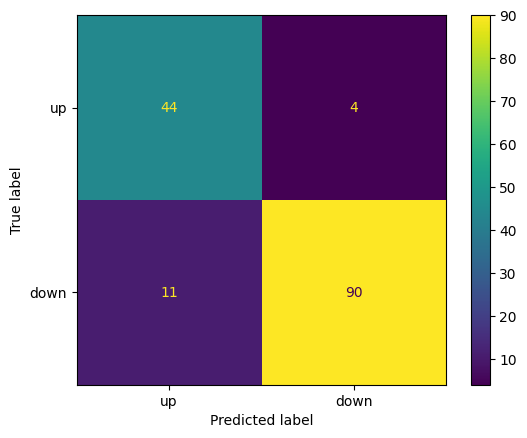

In [83]:
cm = confusion_matrix(y_test, class_gpfit.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['up', 'down'])
disp.plot()
plt.show()